In [1]:
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from catboost import CatBoostClassifier, Pool
from catboost.text_processing import Tokenizer

from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import transformers as ppb
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, log_loss, classification_report
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

C:\Users\Stepan\kaggle\digit_recognizer\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_file_path = r"C:\Users\Stepan\Desktop\vk_test\train_spam.csv"
test_file_path = r"C:\Users\Stepan\Desktop\vk_test\test_spam.csv"

train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)
train_df.shape

(16278, 2)

In [3]:
a = pd.read_csv(test_file_path)
a

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...
...,...
4065,husband to wifetum meri zindagi hoorwifeor kya...
4066,baylor enron case study cindy yes i shall co a...
4067,boring as compared to tp
4068,hellogorgeous hows u my fone was on charge lst...


In [4]:
train_df['text'][1]

'a resume for john lavorato thanks vince i will get moving on it right away molly vince j kaminski 02 21 2001 05 55 pm to molly magee hou ect ect cc vince j kaminski hou ect ect subject a resume for john lavorato molly please make arrangements for the interview with this candidate for a trading position interviews with john lavorato jeff shankman gary hickerson stinson gibner i talked to him in new york and he is considering other opportunities so we have to act fast i think john will like him more than punit thanks'

In [5]:
train_df.groupby('text_type').describe()

text                                                            \
           count unique                                                top   
text_type                                                                    
ham        11469  11458  SPAM ALERT  🚔  User:     Username: @DillyBubbl...   
spam        4809   4809  plzz visit my website moviesgodml to get all m...   

                
          freq  
text_type       
ham          7  
spam         1

In [6]:
count_ham_value, count_spam_value = train_df['text_type'].value_counts()


print(f'How many a ham message: {count_ham_value}\nHow many a spam message: {count_spam_value}')

How many a ham message: 11469
How many a spam message: 4809


In [7]:
11469/16278

0.7045705860670844

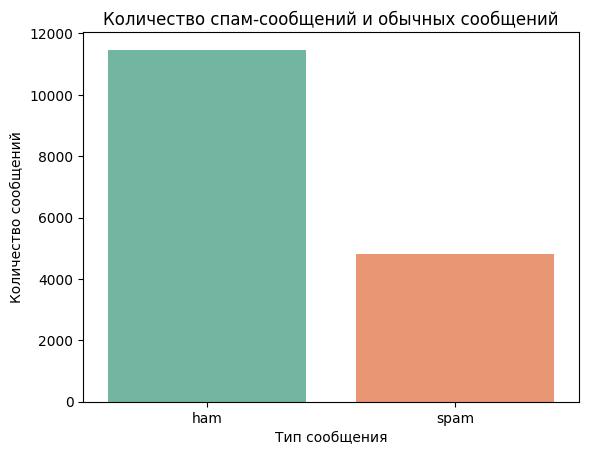

In [8]:
sns.barplot(x=['ham', 'spam'], y=[count_ham_value, count_spam_value], palette="Set2")
plt.xlabel('Тип сообщения')
plt.ylabel('Количество сообщений')
plt.title('Количество спам-сообщений и обычных сообщений')
plt.show()

Можно заметить явный дизбаланс классов
Скорее всего модели будут охотней предсказывать ham сообщения, чтобы минизировать функцию ошибки

In [9]:
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16278 entries, 0 to 16277
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_type  16278 non-null  object
 1   text       16278 non-null  object
dtypes: object(2)
memory usage: 254.5+ KB


,text_type,text
count,16278,16278
unique,2,16267
top,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
freq,11469,7


Давайте извлечем некоторые фичи: длина сообщений, кол-во слов в сообщениях

In [10]:
train_df['text'] = train_df['text'].apply(lambda x: x.lower())
train_df["length"] = train_df["text"].apply(len) # get the length of the text message
train_df["num_words"] = train_df["text"].apply(lambda x: len(re.findall(r'\w+', x))) # Count the number of words in the message 
train_df['label'] = train_df['text_type'].map({'ham': 0, 'spam': 1})
train_df.head()

,text_type,text,length,num_words,label
0,ham,make sure alex knows his birthday is over in f...,86,16,0
1,ham,a resume for john lavorato thanks vince i will...,520,97,0
2,spam,plzz visit my website moviesgodml to get all m...,126,22,1
3,spam,urgent your mobile number has been awarded wit...,139,23,1
4,ham,overview of hr associates analyst project per ...,733,127,0


This will help our model to have more features so it can predict based on length of messages

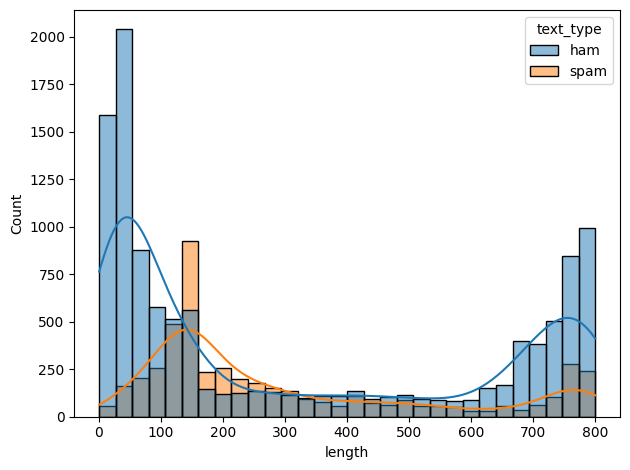

In [11]:
sns.histplot(data=train_df, x="length", hue="text_type", bins=30, kde=True)
plt.tight_layout()
plt.show()

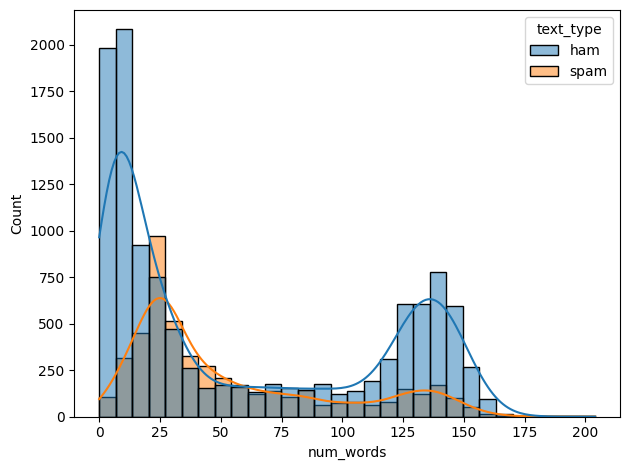

In [12]:
sns.histplot(data=train_df, x="num_words", hue="text_type", bins=30, kde=True)
plt.tight_layout()
plt.show()

In [13]:
train_df['num_words'].max()

204

Посмотрим на максимальную длинну наших сообщений

In [14]:
train_df["length"].max()

800

In [15]:
train_df[train_df["length"]==800]["text"].iloc[0]

'welcome to jefferson pilot s gateway to wealth as one of the industry s premier producers you must continually seek qualified cutting edge services financial profiles concept profiles professional is a personal and business analysis tool that analyzes a client s insurance investment and financial planning goals to help them see their situation today compared to their objectives market profiles professional is an ideal tool for true financial planning it not only provides a thorough analysis including asset allocation but it can calculate tax implications in a client s plan due to its modular format it can be used for specific planning needs as well as more comprehensive planning benefits this software not only provides exceptional analysis but excels in providing simple as well as comprehe'

In [16]:
train_df[train_df["length"] == train_df["length"].min()]["text"].iloc[0]

'🙁'

EMOJII ^^

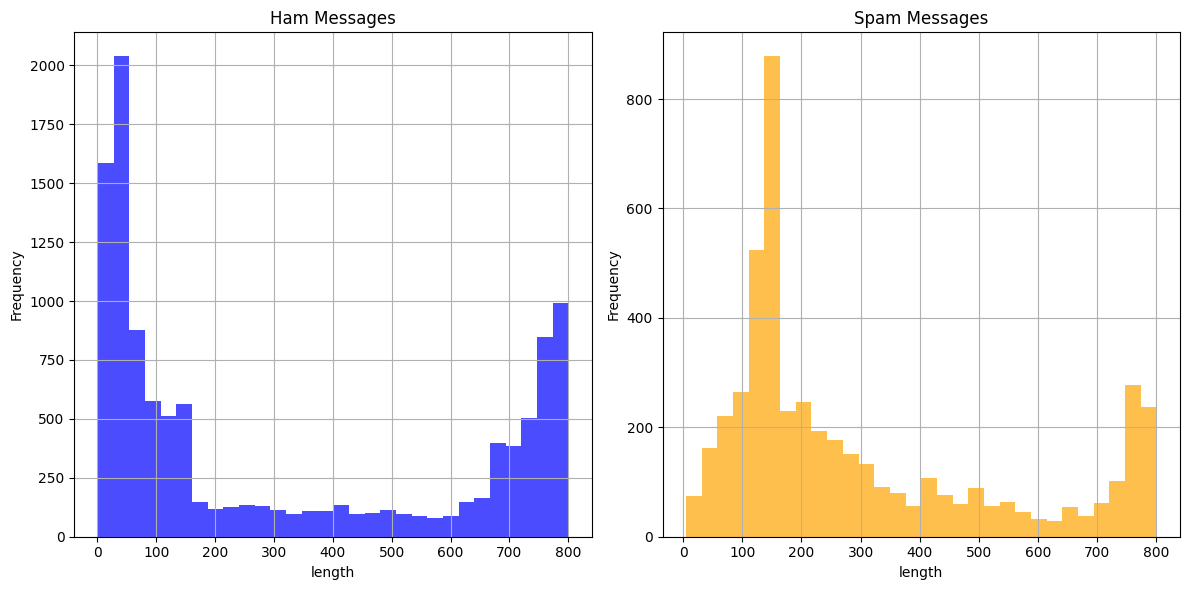

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Построение гистограммы для длины сообщений, разделенной по типу сообщений
train_df[train_df['text_type'] == 'ham'].hist(column='length', bins=30, ax=axes[0], color='blue',alpha=0.7)
axes[0].set_title('Ham Messages')
axes[0].set_xlabel('length')
axes[0].set_ylabel('Frequency')

train_df[train_df['text_type'] == 'spam'].hist(column='length', bins=30, ax=axes[1], color='orange',alpha=0.7)
axes[1].set_title('Spam Messages')
axes[1].set_xlabel('length')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [18]:
def clean_sentence(s):
    stop_words = set(stopwords.words('english'))
    s = s.translate(str.maketrans('','',string.punctuation)) # remove punctuation
    tokens = word_tokenize(s)
    cleaned_s = [w for w in tokens if w not in stop_words] # removing stop-words
    return " ".join(cleaned_s)


clean_data = train_df.copy()
clean_data['text'] = clean_data['text'].apply(clean_sentence)

In [19]:
clean_data["length_cleaned"] = clean_data["text"].apply(len) # get the length of the text message
clean_data["num_words_cleaned"] = clean_data["text"].apply(lambda x: len(re.findall(r'\w+', x)))
clean_data.head()

,text_type,text,length,num_words,label,length_cleaned,num_words_cleaned
0,ham,make sure alex knows birthday fifteen minutes ...,86,16,0,65,10
1,ham,resume john lavorato thanks vince get moving r...,520,97,0,400,64
2,spam,plzz visit website moviesgodml get movies free...,126,22,1,99,14
3,spam,urgent mobile number awarded £2000 prize guara...,139,23,1,108,16
4,ham,overview hr associates analyst project per dav...,733,127,0,632,99


Посмотрим на наши графики после очистики предложений

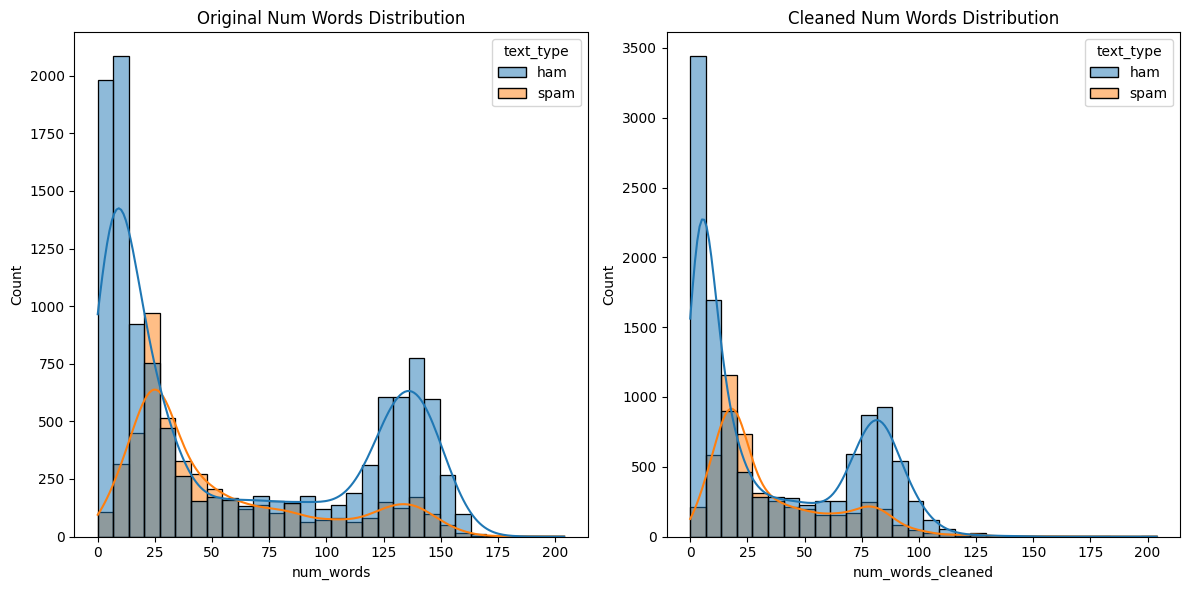

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(data=clean_data, x="num_words", hue="text_type", bins=30, kde=True, ax=axes[0])
axes[0].set_title("Original Num Words Distribution")

sns.histplot(data=clean_data, x="num_words_cleaned", hue="text_type", bins=30, kde=True, ax=axes[1])
axes[1].set_title("Cleaned Num Words Distribution")

plt.tight_layout()
plt.show()

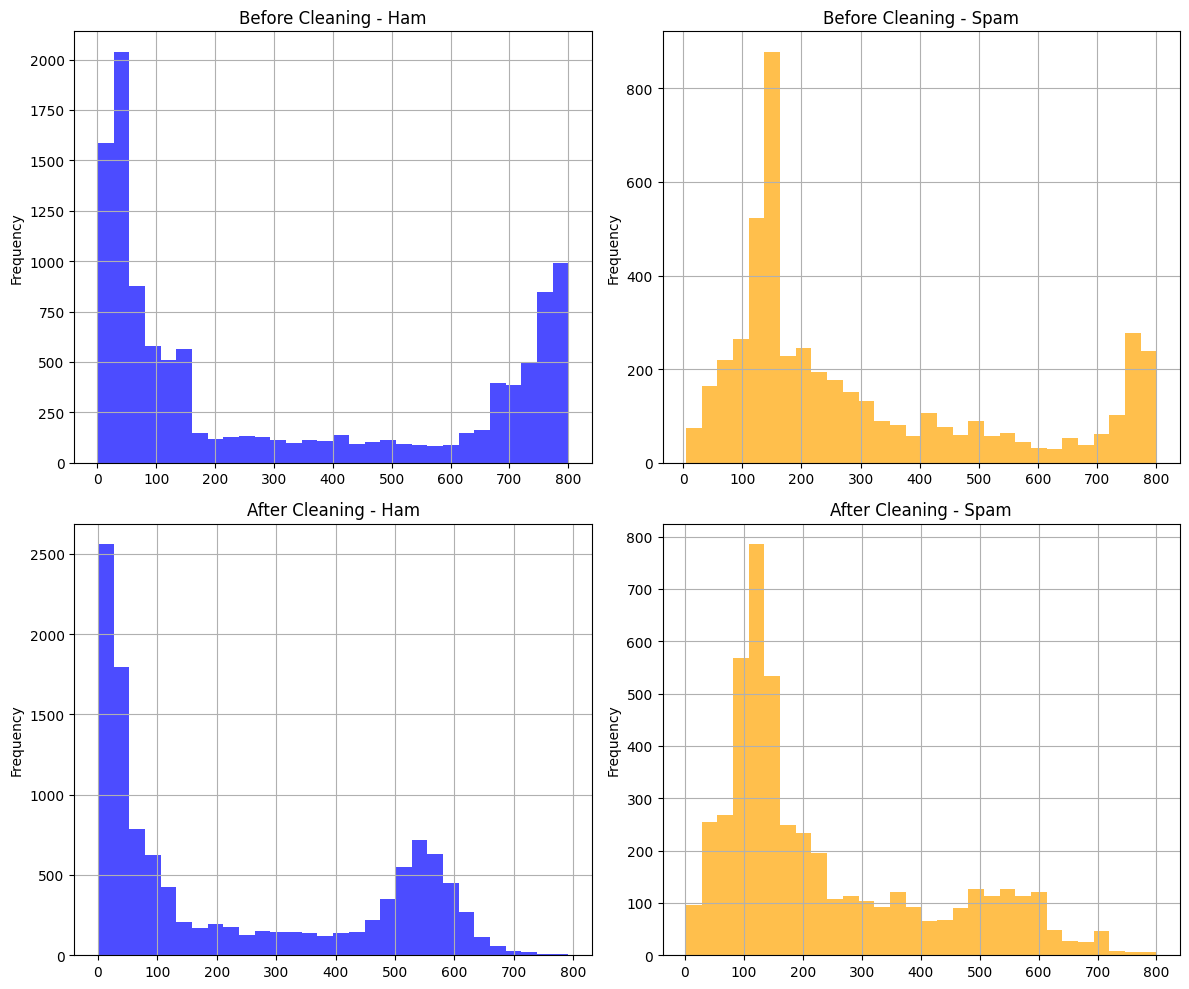

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

clean_data[clean_data['text_type'] == 'ham'].hist(column='length', bins=30, ax=axes[0, 0], color='blue', alpha=0.7)
axes[0, 0].set_title('Before Cleaning - Ham')
axes[0, 0].set_ylabel('Frequency')

clean_data[clean_data['text_type'] == 'spam'].hist(column='length', bins=30, ax=axes[0, 1], color='orange', alpha=0.7)
axes[0, 1].set_title('Before Cleaning - Spam')
axes[0, 1].set_ylabel('Frequency')

clean_data[clean_data['text_type'] == 'ham'].hist(column='length_cleaned', bins=30, ax=axes[1, 0], color='blue', alpha=0.7)
axes[1, 0].set_title('After Cleaning - Ham')
axes[1, 0].set_ylabel('Frequency')

clean_data[clean_data['text_type'] == 'spam'].hist(column='length_cleaned', bins=30, ax=axes[1, 1], color='orange', alpha=0.7)
axes[1, 1].set_title('After Cleaning - Spam')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

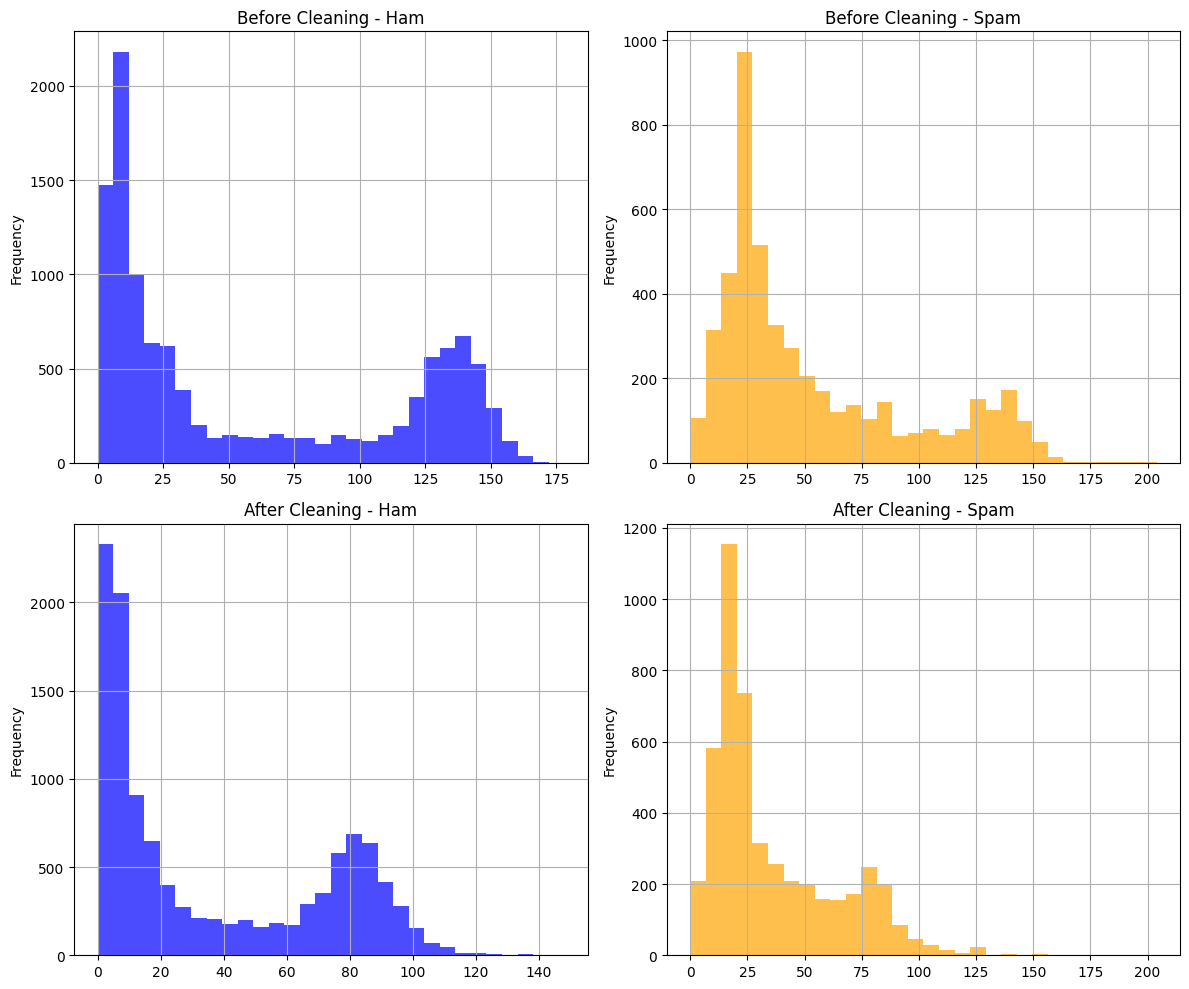

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

clean_data[clean_data['text_type'] == 'ham'].hist(column='num_words', bins=30, ax=axes[0, 0], color='blue', alpha=0.7)
axes[0, 0].set_title('Before Cleaning - Ham')
axes[0, 0].set_ylabel('Frequency')

clean_data[clean_data['text_type'] == 'spam'].hist(column='num_words', bins=30, ax=axes[0, 1], color='orange', alpha=0.7)
axes[0, 1].set_title('Before Cleaning - Spam')
axes[0, 1].set_ylabel('Frequency')

clean_data[clean_data['text_type'] == 'ham'].hist(column='num_words_cleaned', bins=30, ax=axes[1, 0], color='blue', alpha=0.7)
axes[1, 0].set_title('After Cleaning - Ham')
axes[1, 0].set_ylabel('Frequency')

clean_data[clean_data['text_type'] == 'spam'].hist(column='num_words_cleaned', bins=30, ax=axes[1, 1], color='orange', alpha=0.7)
axes[1, 1].set_title('After Cleaning - Spam')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [23]:
print(clean_data.shape)
clean_data.head()

(16278, 7)


,text_type,text,length,num_words,label,length_cleaned,num_words_cleaned
0,ham,make sure alex knows birthday fifteen minutes ...,86,16,0,65,10
1,ham,resume john lavorato thanks vince get moving r...,520,97,0,400,64
2,spam,plzz visit website moviesgodml get movies free...,126,22,1,99,14
3,spam,urgent mobile number awarded £2000 prize guara...,139,23,1,108,16
4,ham,overview hr associates analyst project per dav...,733,127,0,632,99


In [24]:
clean_data.drop(clean_data[clean_data['length_cleaned'] == 0].index, inplace=True)
clean_data.reset_index(drop=True, inplace=True)
print(clean_data.shape)
clean_data.head()

(16270, 7)


,text_type,text,length,num_words,label,length_cleaned,num_words_cleaned
0,ham,make sure alex knows birthday fifteen minutes ...,86,16,0,65,10
1,ham,resume john lavorato thanks vince get moving r...,520,97,0,400,64
2,spam,plzz visit website moviesgodml get movies free...,126,22,1,99,14
3,spam,urgent mobile number awarded £2000 prize guara...,139,23,1,108,16
4,ham,overview hr associates analyst project per dav...,733,127,0,632,99


In [25]:
train_df.loc[train_df['num_words'] == 0]

,text_type,text,length,num_words,label
5661,ham,🙁,1,0,0
6798,ham,👍,1,0,0
8865,ham,😊,1,0,0
9317,spam,✅✅✅✅✅✅✅✅✅✅✅✅✅,13,0,1
11547,ham,😳😳,2,0,0
14258,ham,😐,1,0,0


In [26]:
clean_data.loc[clean_data['num_words_cleaned'] == 0]

,text_type,text,length,num_words,label,length_cleaned,num_words_cleaned
5659,ham,🙁,1,0,0,1,0
6796,ham,👍,1,0,0,1,0
8862,ham,😊,1,0,0,1,0
9314,spam,✅✅✅✅✅✅✅✅✅✅✅✅✅,13,0,1,13,0
11541,ham,😳😳,2,0,0,2,0
14251,ham,😐,1,0,0,1,0


In [27]:
clean_data.drop(clean_data[clean_data['num_words_cleaned'] == 0].index, inplace=True)
clean_data.reset_index(drop=True, inplace=True)
print(clean_data.shape)
clean_data.head()

(16264, 7)


,text_type,text,length,num_words,label,length_cleaned,num_words_cleaned
0,ham,make sure alex knows birthday fifteen minutes ...,86,16,0,65,10
1,ham,resume john lavorato thanks vince get moving r...,520,97,0,400,64
2,spam,plzz visit website moviesgodml get movies free...,126,22,1,99,14
3,spam,urgent mobile number awarded £2000 prize guara...,139,23,1,108,16
4,ham,overview hr associates analyst project per dav...,733,127,0,632,99


In [28]:
clean_data.loc[clean_data['length_cleaned'] == 0]

,text_type,text,length,num_words,label,length_cleaned,num_words_cleaned


In [29]:
clean_data.loc[clean_data['num_words_cleaned'] == 0]

,text_type,text,length,num_words,label,length_cleaned,num_words_cleaned


# Имеют ли спам сообещния больше слов?

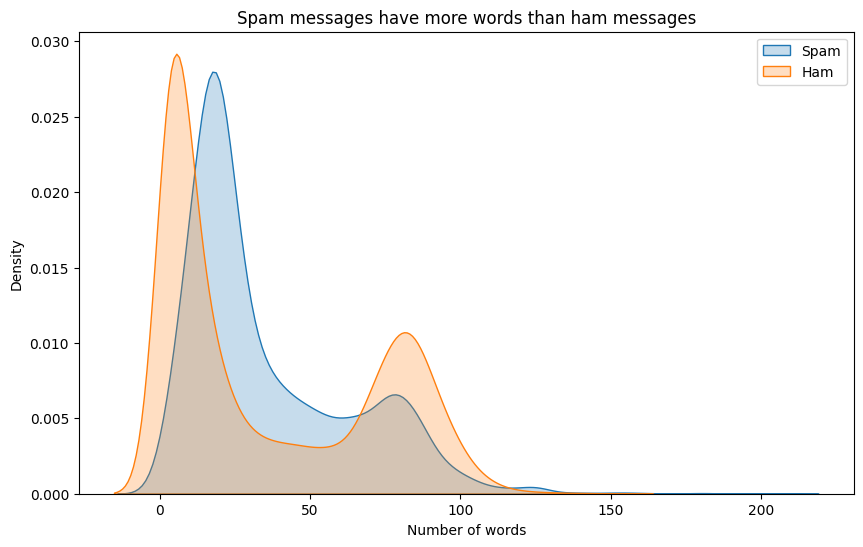

In [30]:
f, ax = plt.subplots(figsize=(10, 6))

sns.kdeplot(clean_data[clean_data['label'] == 1]['num_words_cleaned'], label='Spam', shade=True)
sns.kdeplot(clean_data[clean_data['label'] == 0]['num_words_cleaned'], label='Ham', shade=True)
ax.set(xlabel = "Number of words", ylabel = "Density",title = "Spam messages have more words than ham messages")
plt.legend()
plt.show()

График показывает, что явного отличия в длине сообщений у нас нет(

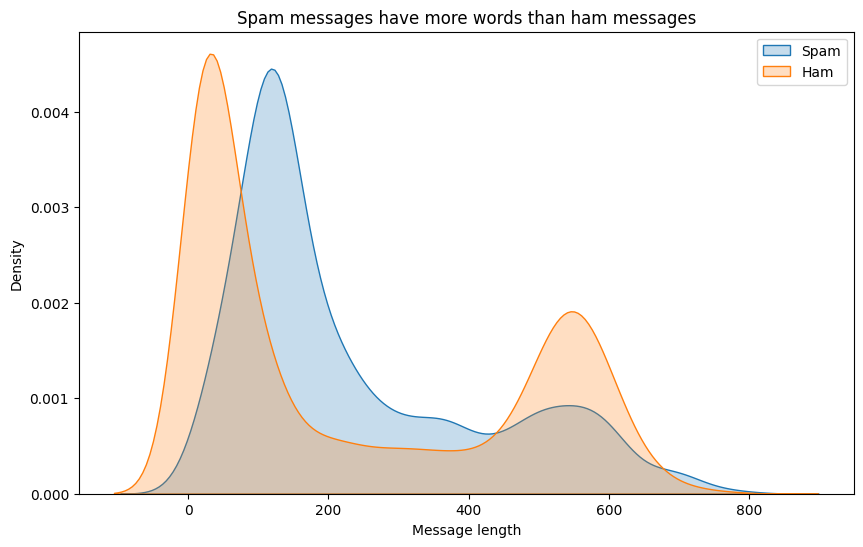

In [31]:
f, ax = plt.subplots(figsize=(10, 6))

sns.kdeplot(clean_data[clean_data['label'] == 1]['length_cleaned'], label='Spam', shade=True)
sns.kdeplot(clean_data[clean_data['label'] == 0]['length_cleaned'], label='Ham', shade=True)
ax.set(xlabel = "Message length", ylabel = "Density",title = "Spam messages have more words than ham messages")
plt.legend()
plt.show()

Из этих графиков можно вычленить 2 вещи:
  * Особой разницы в длине и количестве слов в сообщениях нет 
  * Основная доля спам сообщений это достаточно короткие письма(от 10 до 200 символов) , к моему удивлению :& 

Создадим функцию, которая будет обучать модель и считать метрики качества

In [32]:
def fit_and_compute_accuracy(X_train, X_val, y_train, y_val, model, model_param=None):
    if model_param:
        model = model(**model_param)
    else:
        model = model()
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    y_pred_class = model.predict(X_val)
    
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    logloss = log_loss(y_val, y_pred_proba)
    classification_rep = classification_report(y_val, y_pred_class)
    
    print(f'\nROC AUC Score: {roc_auc}\n')
    print(f'Log Loss: {logloss}')
    print('---------------------------------\n')
    print(classification_rep)
    
    results = pd.DataFrame(
        data={'Вероятность': y_pred_proba, 'Предсказанный класс': y_pred_class, 'Истинный класс': y_val}
    )
    return model, results           

# Разделим обучающаю выборку на train и valid

In [33]:
X, Y = clean_data['text'], clean_data['label']

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=26)

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of Y_train: {Y_train.shape}')
print('---------------------------------')
print(f'Shape of X_val: {X_val.shape}')
print(f'Shape of Y_val: {Y_val.shape}')

clean_data['label'].dtype

Shape of X_train: (13011,)
Shape of Y_train: (13011,)
---------------------------------
Shape of X_val: (3253,)
Shape of Y_val: (3253,)


dtype('int64')

Давайте выберем **бейзлайн** - очень простая модель, с которой мы в дальнейшем будем сравниваться.
Пусть в нашем случае это будет **LogisticRegression**

Так же создадим векторайзер, который будет преобразовывать наши тестовые данные


In [34]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

In [35]:
fit_and_compute_accuracy(X_train_tfidf, X_val_tfidf, Y_train, Y_val, LogisticRegression)


ROC AUC Score: 0.9740483767256909

Log Loss: 0.24851303861415416
---------------------------------

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      2297
           1       0.91      0.79      0.85       956

    accuracy                           0.92      3253
   macro avg       0.92      0.88      0.89      3253
weighted avg       0.92      0.92      0.91      3253



(LogisticRegression(),
        Вероятность  Предсказанный класс  Истинный класс
 7073      0.129325                    0               0
 4068      0.092753                    0               0
 14497     0.148556                    0               0
 9775      0.295754                    0               0
 6438      0.307011                    0               0
 ...            ...                  ...             ...
 5753      0.383123                    0               1
 13872     0.122130                    0               0
 4762      0.740374                    1               1
 4342      0.834238                    1               1
 15864     0.126746                    0               0
 
 [3253 rows x 3 columns])

Как можем заметить, наша модель неплохо себя показывает на валидаоных данных, даже слишком неплохо

Вывод: модель хорошо справляется с классификацией объектов класса 0, но чуть хуже - с объектами класса 1.

Как можем вспомнить, что у нас есть дизбаланс в данных, давайте попробуем штрафать модель за неправильное определение

In [36]:
param_model = {'class_weight': {0: 0.7, 1: 0.3}}
fit_and_compute_accuracy(X_train_tfidf, X_val_tfidf, Y_train, Y_val, LogisticRegression, param_model)


ROC AUC Score: 0.9675354245942043

Log Loss: 0.33251763659212397
---------------------------------

              precision    recall  f1-score   support

           0       0.81      0.99      0.89      2297
           1       0.95      0.43      0.60       956

    accuracy                           0.83      3253
   macro avg       0.88      0.71      0.74      3253
weighted avg       0.85      0.83      0.80      3253



(LogisticRegression(class_weight={0: 0.7, 1: 0.3}),
        Вероятность  Предсказанный класс  Истинный класс
 7073      0.107712                    0               0
 4068      0.088430                    0               0
 14497     0.107594                    0               0
 9775      0.199865                    0               0
 6438      0.212019                    0               0
 ...            ...                  ...             ...
 5753      0.204402                    0               1
 13872     0.100147                    0               0
 4762      0.475470                    0               1
 4342      0.569320                    1               1
 15864     0.103003                    0               0
 
 [3253 rows x 3 columns])

In [37]:
param_model = {'class_weight': 'balanced'}
fit_and_compute_accuracy(X_train_tfidf, X_val_tfidf, Y_train, Y_val, LogisticRegression, param_model)


ROC AUC Score: 0.9740729676510931

Log Loss: 0.2684199132332427
---------------------------------

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      2297
           1       0.85      0.92      0.88       956

    accuracy                           0.93      3253
   macro avg       0.91      0.93      0.92      3253
weighted avg       0.93      0.93      0.93      3253



(LogisticRegression(class_weight='balanced'),
        Вероятность  Предсказанный класс  Истинный класс
 7073      0.206380                    0               0
 4068      0.150987                    0               0
 14497     0.235004                    0               0
 9775      0.422139                    0               0
 6438      0.445125                    0               0
 ...            ...                  ...             ...
 5753      0.545721                    1               1
 13872     0.192361                    0               0
 4762      0.843035                    1               1
 4342      0.905933                    1               1
 15864     0.187169                    0               0
 
 [3253 rows x 3 columns])

## RandomForestClassifier 

In [38]:
fit_and_compute_accuracy(X_train_tfidf, X_val_tfidf, Y_train, Y_val, RandomForestClassifier)


ROC AUC Score: 0.9803891923793634

Log Loss: 0.207767935545246
---------------------------------

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      2297
           1       0.98      0.79      0.88       956

    accuracy                           0.94      3253
   macro avg       0.95      0.89      0.92      3253
weighted avg       0.94      0.94      0.93      3253



(RandomForestClassifier(),
        Вероятность  Предсказанный класс  Истинный класс
 7073      0.130000                    0               0
 4068      0.006428                    0               0
 14497     0.130500                    0               0
 9775      0.173063                    0               0
 6438      0.361608                    0               0
 ...            ...                  ...             ...
 5753      0.400000                    0               1
 13872     0.003341                    0               0
 4762      0.910000                    1               1
 4342      0.941213                    1               1
 15864     0.052826                    0               0
 
 [3253 rows x 3 columns])

In [39]:
param_model = {'class_weight': 'balanced'}
fit_and_compute_accuracy(X_train_tfidf, X_val_tfidf, Y_train, Y_val, RandomForestClassifier, param_model)


ROC AUC Score: 0.9813400414949097

Log Loss: 0.2119915474744555
---------------------------------

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      2297
           1       0.98      0.79      0.87       956

    accuracy                           0.93      3253
   macro avg       0.95      0.89      0.91      3253
weighted avg       0.94      0.93      0.93      3253



(RandomForestClassifier(class_weight='balanced'),
        Вероятность  Предсказанный класс  Истинный класс
 7073      0.110000                    0               0
 4068      0.029095                    0               0
 14497     0.100000                    0               0
 9775      0.137367                    0               0
 6438      0.341921                    0               0
 ...            ...                  ...             ...
 5753      0.310000                    0               1
 13872     0.040000                    0               0
 4762      0.910000                    1               1
 4342      0.900000                    1               1
 15864     0.092788                    0               0
 
 [3253 rows x 3 columns])

In [40]:
param_model = {'class_weight': {0: 0.7, 1: 0.3}}
fit_and_compute_accuracy(X_train_tfidf, X_val_tfidf, Y_train, Y_val, RandomForestClassifier, param_model)


ROC AUC Score: 0.9788549918667793

Log Loss: 0.2061505555411101
---------------------------------

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      2297
           1       0.97      0.78      0.87       956

    accuracy                           0.93      3253
   macro avg       0.94      0.89      0.91      3253
weighted avg       0.93      0.93      0.93      3253



(RandomForestClassifier(class_weight={0: 0.7, 1: 0.3}),
        Вероятность  Предсказанный класс  Истинный класс
 7073      0.080000                    0               0
 4068      0.002935                    0               0
 14497     0.020000                    0               0
 9775      0.291064                    0               0
 6438      0.420246                    0               0
 ...            ...                  ...             ...
 5753      0.290000                    0               1
 13872     0.000000                    0               0
 4762      0.870000                    1               1
 4342      0.860000                    1               1
 15864     0.040455                    0               0
 
 [3253 rows x 3 columns])

Обе модели демонстрируют высокие показатели точности, полноты и F1-меры для обоих классов. Они показывают почти одинаковые результаты по всем метрикам, что указывает на то, что обе модели хорошо справляются с задачей классификации спама и не спама.

Однако следует отметить, что recall (полнота) для класса 1 (спам) немного ниже, чем для класса 0 (не спам), что может указывать на то, что модели склонны недооценивать спамовые сообщения. Возможно, улучшение работы с классом спама потребует дополнительных мер или настроек модели.

В целом, обе модели хорошо справляются с задачей классификации текста, и выбор между ними может зависеть от конкретных требований проекта, времени обучения или других факторов.

## CatBoostClassifier

In [41]:
param_cb = {
    'iterations': 1000, 
    'learning_rate': 0.1, 
    'depth': 6, 
    'loss_function': 'Logloss',
    'verbose': 100,
    'task_type': 'GPU',
    'class_weights': {0: 0.7, 1: 0.3}
}

fit_and_compute_accuracy(X_train_tfidf, X_val_tfidf, Y_train, Y_val, CatBoostClassifier, param_cb)

0:	learn: 0.5970851	total: 205ms	remaining: 3m 24s
100:	learn: 0.1926003	total: 12.2s	remaining: 1m 48s
200:	learn: 0.1564182	total: 23.7s	remaining: 1m 34s
300:	learn: 0.1392022	total: 34.9s	remaining: 1m 21s
400:	learn: 0.1296646	total: 46.1s	remaining: 1m 8s
500:	learn: 0.1207290	total: 57.3s	remaining: 57.1s
600:	learn: 0.1152992	total: 1m 8s	remaining: 45.3s
700:	learn: 0.1104973	total: 1m 19s	remaining: 33.8s
800:	learn: 0.1065606	total: 1m 30s	remaining: 22.4s
900:	learn: 0.1034300	total: 1m 41s	remaining: 11.1s
999:	learn: 0.1008175	total: 1m 51s	remaining: 0us

ROC AUC Score: 0.9734650253286532

Log Loss: 0.21603331629110478
---------------------------------

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      2297
           1       0.97      0.72      0.83       956

    accuracy                           0.91      3253
   macro avg       0.93      0.86      0.88      3253
weighted avg       0.92      0.91      0.91      32

(<catboost.core.CatBoostClassifier at 0x28d86178310>,
        Вероятность  Предсказанный класс  Истинный класс
 7073      0.066210                    0               0
 4068      0.045229                    0               0
 14497     0.045229                    0               0
 9775      0.157763                    0               0
 6438      0.339563                    0               0
 ...            ...                  ...             ...
 5753      0.744127                    1               1
 13872     0.001870                    0               0
 4762      0.958984                    1               1
 4342      0.965162                    1               1
 15864     0.000865                    0               0
 
 [3253 rows x 3 columns])

In [42]:
param_cb = {
    'iterations': 1000, 
    'learning_rate': 0.1, 
    'depth': 6, 
    'loss_function': 'Logloss',
    'verbose': 100,
    'task_type': 'GPU',
    'auto_class_weights': 'Balanced'
}

fit_and_compute_accuracy(X_train_tfidf, X_val_tfidf, Y_train, Y_val, CatBoostClassifier, param_cb)

0:	learn: 0.6392260	total: 148ms	remaining: 2m 27s
100:	learn: 0.2849473	total: 12.2s	remaining: 1m 48s
200:	learn: 0.2279091	total: 23.6s	remaining: 1m 33s
300:	learn: 0.2009894	total: 34.8s	remaining: 1m 20s
400:	learn: 0.1854927	total: 45.8s	remaining: 1m 8s
500:	learn: 0.1784872	total: 56.8s	remaining: 56.6s
600:	learn: 0.1719324	total: 1m 7s	remaining: 45s
700:	learn: 0.1614969	total: 1m 18s	remaining: 33.7s
800:	learn: 0.1581074	total: 1m 29s	remaining: 22.3s
900:	learn: 0.1483670	total: 1m 40s	remaining: 11.1s
999:	learn: 0.1444437	total: 1m 51s	remaining: 0us

ROC AUC Score: 0.9760468448021159

Log Loss: 0.20367987328955955
---------------------------------

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2297
           1       0.91      0.88      0.90       956

    accuracy                           0.94      3253
   macro avg       0.93      0.92      0.93      3253
weighted avg       0.94      0.94      0.94      3253

(<catboost.core.CatBoostClassifier at 0x28d86386b90>,
        Вероятность  Предсказанный класс  Истинный класс
 7073      0.187582                    0               0
 4068      0.133556                    0               0
 14497     0.130505                    0               0
 9775      0.475511                    0               0
 6438      0.454839                    0               0
 ...            ...                  ...             ...
 5753      0.790006                    1               1
 13872     0.013883                    0               0
 4762      0.968584                    1               1
 4342      0.952011                    1               1
 15864     0.000548                    0               0
 
 [3253 rows x 3 columns])

Ранее я удалил все строки, содержащие эмодзи, сейчас я хочу попробовать оставить эти строки и обучить модель вместе с ними

In [44]:
data_for_catboost = train_df.copy()
data_for_catboost

,text_type,text,length,num_words,label
0,ham,make sure alex knows his birthday is over in f...,86,16,0
1,ham,a resume for john lavorato thanks vince i will...,520,97,0
2,spam,plzz visit my website moviesgodml to get all m...,126,22,1
3,spam,urgent your mobile number has been awarded wit...,139,23,1
4,ham,overview of hr associates analyst project per ...,733,127,0
...,...,...,...,...,...
16273,spam,if you are interested in binary options tradin...,114,18,1
16274,spam,dirty pictureblyk on aircel thanks you for bei...,454,73,1
16275,ham,or you could do this g on mon 1635465 sep 1635...,799,147,0
16276,ham,insta reels par 80 गंद bhara pada hai 👀 kuch b...,102,20,0


In [45]:
data_for_catboost.loc[data_for_catboost['num_words'] == 0]

,text_type,text,length,num_words,label
5661,ham,🙁,1,0,0
6798,ham,👍,1,0,0
8865,ham,😊,1,0,0
9317,spam,✅✅✅✅✅✅✅✅✅✅✅✅✅,13,0,1
11547,ham,😳😳,2,0,0
14258,ham,😐,1,0,0


In [46]:
data_for_catboost.loc[data_for_catboost['length'] == 1]

,text_type,text,length,num_words,label
5661,ham,🙁,1,0,0
6798,ham,👍,1,0,0
6888,ham,o,1,1,0
8114,ham,k,1,1,0
8402,ham,f,1,1,0
8865,ham,😊,1,0,0
14258,ham,😐,1,0,0
14344,ham,i,1,1,0


Как можно увидеть, мы удалили все сообщения, длина которых 0, но оставили сообщения, в которых количество слов 0, а длина сообщения != 0

In [47]:
cb_tokenizer = Tokenizer(separator_type='BySense',
                         token_types=['Word', 'Number', 'Unknown'])

In [48]:
def clean_sentence_cb(s):
    stop_words = set(stopwords.words('english'))
    s = s.translate(str.maketrans('','',string.punctuation))
    tokens = cb_tokenizer.tokenize(s)
    cleaned_s = [w for w in tokens if w not in stop_words]
    return " ".join(cleaned_s)

data_for_catboost['text'] = data_for_catboost['text'].apply(clean_sentence_cb)

In [49]:
data_for_catboost.head()

,text_type,text,length,num_words,label
0,ham,make sure alex knows birthday fifteen minutes ...,86,16,0
1,ham,resume john lavorato thanks vince get moving r...,520,97,0
2,spam,plzz visit website moviesgodml get movies free...,126,22,1
3,spam,urgent mobile number awarded £ 2000 prize guar...,139,23,1
4,ham,overview hr associates analyst project per dav...,733,127,0


In [50]:
X_cb, y_cb = data_for_catboost['text'], data_for_catboost['label']

X_train_cb, X_val_cb, y_train_cb, y_val_cb = train_test_split(X_cb, y_cb, test_size=0.2, random_state=26)


In [51]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)
X_train_cb_tfidf = tfidf_vectorizer.fit_transform(X_train_cb)
X_val_cb_tfidf = tfidf_vectorizer.transform(X_val_cb)

In [55]:
X_val_cb

7075     𝑰 𝒓 𝒆 𝒂 𝒍 𝒍 𝒚 𝒂 𝒑 𝒑 𝒓 𝒆 𝒄 𝒊 𝒂 𝒕 𝒆 𝒂 𝒍 𝒍 𝒚 𝒐 𝒖 ...
11401    4mths half price orange line rental latest cam...
11877    petrochem desk vasant seems help kate help pro...
9781     ➖ ➖ ➖ ➖ ➖ ➖ ➖ ➖ ➖ ➖ ➖ ➖ ⭕ 𝗦 𝗧 𝗘 𝗣 1 𝙹 𝙾 𝙸 𝙽 𝚃 ...
15700           baby promise treat well bet take good care
                               ...                        
4763     another bad offrr w starred ant know save 60 p...
5120        designation software developer may get chennai
15878        evaluation form mike please sign return vince
3258     url url date supplied nintendo newsletter 1635...
12428                            url url date supplied url
Name: text, Length: 3256, dtype: object

In [52]:
param_cb = {
    'iterations': 1000, 
    'learning_rate': 0.1, 
    'depth': 6, 
    'loss_function': 'Logloss',
    'verbose': 250,
    'task_type': 'GPU',
    'auto_class_weights': 'Balanced'
}

final_model, results = fit_and_compute_accuracy(X_train_cb_tfidf, X_val_cb_tfidf, y_train_cb, y_val_cb, CatBoostClassifier, param_cb)



0:	learn: 0.6394086	total: 134ms	remaining: 2m 13s
250:	learn: 0.2210131	total: 28s	remaining: 1m 23s
500:	learn: 0.1937345	total: 54.5s	remaining: 54.3s
750:	learn: 0.1708488	total: 1m 21s	remaining: 26.9s
999:	learn: 0.1543909	total: 1m 47s	remaining: 0us

ROC AUC Score: 0.9694090615422547

Log Loss: 0.22454015348944512
---------------------------------

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2282
           1       0.88      0.84      0.86       974

    accuracy                           0.92      3256
   macro avg       0.91      0.90      0.90      3256
weighted avg       0.92      0.92      0.92      3256



AttributeError: 'CatBoostClassifier' object has no attribute 'predictions'

# Сохраняем результаты модели на тестовых данных 

In [58]:
test_data = pd.read_csv(test_file_path)
X_test = test_data['text']
X_test = X_test.apply(clean_sentence_cb)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

predictions_proba = final_model.predict_proba(X_test_tfidf)[:, 1]
predictions = final_model.predict(X_test_tfidf)
results_test_data = pd.DataFrame({'is_spam': predictions, 'score': predictions_proba, 'text': X_test})
results_test_data.to_csv('predictions.csv', index=False)

In [61]:
check = pd.read_csv(r"C:\Users\Stepan\Desktop\vk_test\predictions.csv")
check.value_counts('is_spam')

is_spam
0    2875
1    1195
Name: count, dtype: int64

# Loading the Pre-trained BERT model

Let's now load a pre-trained BERT model.

In [103]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
EPOCHS=10
MAX_LEN=512
BATCH_SIZE=16
LEARNING_RATE = 2e-5

In [126]:
df_bert = pd.read_csv(train_file_path)


In [134]:
model_class, tokenizer_class, pretrained_weights = (
    ppb.BertModel,
    ppb.BertTokenizer,
    'bert-base-uncased'
)

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
df_bert['text'] = df_bert['text'].apply(lambda x: x[:512])

In [136]:
tokenized = df_bert['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [137]:
tokenizer.encode(df_bert['text'][0], add_special_tokens=True)

[101,
 2191,
 2469,
 4074,
 4282,
 2010,
 5798,
 2003,
 2058,
 1999,
 5417,
 2781,
 2004,
 2521,
 2004,
 2115,
 2063,
 4986,
 102]

In [138]:
tokenizer.vocab

OrderedDict([('[PAD]', 0),
             ('[unused0]', 1),
             ('[unused1]', 2),
             ('[unused2]', 3),
             ('[unused3]', 4),
             ('[unused4]', 5),
             ('[unused5]', 6),
             ('[unused6]', 7),
             ('[unused7]', 8),
             ('[unused8]', 9),
             ('[unused9]', 10),
             ('[unused10]', 11),
             ('[unused11]', 12),
             ('[unused12]', 13),
             ('[unused13]', 14),
             ('[unused14]', 15),
             ('[unused15]', 16),
             ('[unused16]', 17),
             ('[unused17]', 18),
             ('[unused18]', 19),
             ('[unused19]', 20),
             ('[unused20]', 21),
             ('[unused21]', 22),
             ('[unused22]', 23),
             ('[unused23]', 24),
             ('[unused24]', 25),
             ('[unused25]', 26),
             ('[unused26]', 27),
             ('[unused27]', 28),
             ('[unused28]', 29),
             ('[unused29]', 30),
  

In [140]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
        
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

In [141]:
np.array(padded).shape

(16278, 609)

In [143]:
attention_mask = np.where(padded != 0,1,0)
attention_mask.shape

(16278, 609)

In [144]:
attention_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

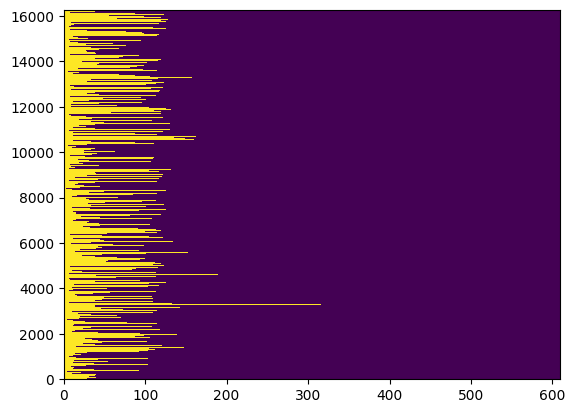

In [145]:
plt.pcolormesh(attention_mask)

In [147]:
max_length = 512

padded = [ids[:max_length] for ids in padded]
attention_mask = [mask[:max_length] for mask in attention_mask]

In [153]:
input_ids = torch.tensor(padded, dtype=torch.long)
attention_mask = torch.tensor(attention_mask, dtype=torch.float)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

ValueError: only one element tensors can be converted to Python scalars

In [157]:
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 25603080192 bytes.

In [151]:
type(attention_mask)

list

In [152]:
attention_mask = torch.tensor(attention_mask, dtype=torch.long)

TypeError: only integer tensors of a single element can be converted to an index

In [156]:
attention_mask = torch.stack(attention_mask)

In [112]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [52]:
def load_imdb_data(data_file):
    df = pd.read_csv(data_file)
    texts = df['text'].tolist()
    labels = [1 if text_type == "spam" else 0 for text_type in df['text_type'].tolist()]
    return texts, labels


texts, labels = load_imdb_data(train_file_path)

In [56]:
class TextClassificationDataset(Dataset):

    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

In [101]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes=2):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.bert.eval()
        for param in self.bert.parameters():
            param.requires_grad = False
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

In [89]:
def train(model, data_loader, optimizer, scheduler, device):
    model.fc.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

In [90]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

In [91]:
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
    return "positive" if preds.item() == 1 else "negative"

In [92]:
 bert_model_name = 'bert-base-uncased'
 max_length = 128
 batch_size = 16
 num_epochs = 4
 learning_rate = 2e-5

In [93]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=26)

In [95]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

In [99]:
optimizer = AdamW(model.fc.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
#scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [100]:
for epoch in range(num_epochs):
    running_loss = 0.0
    model.fc.train()  # Только для вашего слоя fc
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * input_ids.size(0)
    
    # Оценка модели на валидационном наборе данных
    val_labels, val_preds = evaluate(model, val_dataloader)
    val_roc_auc = roc_auc_score(val_labels, val_preds)
    
    # Выводим результаты на каждой эпохе
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_dataset)}, Val ROC AUC: {val_roc_auc}')

KeyboardInterrupt: 